In [180]:
import pandas as pd
import matplotlib.pyplot as plt

Se importan las librerías necesarias para manipulación de datos, visualización y machine learning.

In [181]:
fct_ventas = pd.read_csv('../datasets/interim/fct_ventas.csv')

dim_productos = pd.read_csv('../datasets/interim/dim_productos.csv')

Se crean variables temporales (año, mes, día, día de la semana) a partir de la fecha de entrega para facilitar el análisis temporal.

In [182]:
fct_ventas.head()

,PRODUCTID,PRICE_UNITARIO,QUANTITY,DELIVERYDATE,PRODCATEGORYID,PRICE
0,MB-1034,2499,4,2018-03-11,MB,2499
1,CB-1161,399,9,2018-03-11,CB,399
2,HB-1175,899,2,2018-02-28,HB,899
3,RC-1056,2499,2,2018-02-28,RC,2499
4,CC-1021,1144,3,2018-02-28,CC,1144


Se agregan visualizaciones para observar el comportamiento de las ventas a lo largo del tiempo, segmentado por mes, día y semana.

In [183]:
fct_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   PRODUCTID       1908 non-null   object
 1   PRICE_UNITARIO  1908 non-null   int64 
 2   QUANTITY        1908 non-null   int64 
 3   DELIVERYDATE    1908 non-null   object
 4   PRODCATEGORYID  1908 non-null   object
 5   PRICE           1908 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 89.6+ KB


Se visualiza la cantidad vendida por día para cada categoría de producto.

In [184]:
dim_productos.head()

,PRODUCTID,PRODCATEGORYID,PRICE,SHORT_DESCR,SHORT_DESCR_CAT
0,RO-1001,RO,525,Roady 1001,Road Bike
1,RO-1002,RO,689,Roady 1002,Road Bike
2,RO-1003,RO,721,Roady 1003,Road Bike
3,BX-1011,BX,249,BMX Vintage 1011,BMX
4,BX-1012,BX,399,BMX Jump 1012,BMX


Se codifican las variables categóricas usando One-Hot Encoding. Esto es necesario para que los modelos puedan interpretar estas variables.

In [185]:
dim_productos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   PRODUCTID        42 non-null     object
 1   PRODCATEGORYID   42 non-null     object
 2   PRICE            42 non-null     int64 
 3   SHORT_DESCR      42 non-null     object
 4   SHORT_DESCR_CAT  42 non-null     object
dtypes: int64(1), object(4)
memory usage: 1.8+ KB


Se escalan las variables numéricas para estandarizar sus rangos, lo que beneficia especialmente a modelos sensibles a la escala.

In [186]:
fct_ventas.columns

Index(['PRODUCTID', 'PRICE_UNITARIO', 'QUANTITY', 'DELIVERYDATE',
       'PRODCATEGORYID', 'PRICE'],
      dtype='object')

Se imputan los valores nulos generados por las variables de lag con ceros, lo cual es seguro en contextos de predicción temporal.

In [187]:
dim_productos.columns

Index(['PRODUCTID', 'PRODCATEGORYID', 'PRICE', 'SHORT_DESCR',
       'SHORT_DESCR_CAT'],
      dtype='object')

## 1. Variables Temporales

In [188]:
fct_ventas['DELIVERYDATE'] = pd.to_datetime(fct_ventas['DELIVERYDATE'])


fct_ventas['ANIO'] = fct_ventas['DELIVERYDATE'].dt.year
fct_ventas['MES'] = fct_ventas['DELIVERYDATE'].dt.month
fct_ventas['DIA'] = fct_ventas['DELIVERYDATE'].dt.day_name()

In [189]:
fct_ventas.head()

,PRODUCTID,PRICE_UNITARIO,QUANTITY,DELIVERYDATE,PRODCATEGORYID,PRICE,ANIO,MES,DIA
0,MB-1034,2499,4,2018-03-11,MB,2499,2018,3,Sunday
1,CB-1161,399,9,2018-03-11,CB,399,2018,3,Sunday
2,HB-1175,899,2,2018-02-28,HB,899,2018,2,Wednesday
3,RC-1056,2499,2,2018-02-28,RC,2499,2018,2,Wednesday
4,CC-1021,1144,3,2018-02-28,CC,1144,2018,2,Wednesday


## 2. Creación de variable derivada: Ingreso total

In [190]:
fct_ventas['INGRESO_TOTAL'] = fct_ventas['PRICE_UNITARIO'] * fct_ventas['QUANTITY']

In [191]:
fct_ventas.head()

,PRODUCTID,PRICE_UNITARIO,QUANTITY,DELIVERYDATE,PRODCATEGORYID,PRICE,ANIO,MES,DIA,INGRESO_TOTAL
0,MB-1034,2499,4,2018-03-11,MB,2499,2018,3,Sunday,9996
1,CB-1161,399,9,2018-03-11,CB,399,2018,3,Sunday,3591
2,HB-1175,899,2,2018-02-28,HB,899,2018,2,Wednesday,1798
3,RC-1056,2499,2,2018-02-28,RC,2499,2018,2,Wednesday,4998
4,CC-1021,1144,3,2018-02-28,CC,1144,2018,2,Wednesday,3432


## 3. Agregaciones

Agregaciones: Ventas por producto

In [192]:
ventas_por_producto = fct_ventas.groupby('PRODUCTID').agg({
    'QUANTITY': 'sum',
    'INGRESO_TOTAL': 'sum'
}).reset_index()

Agregaciones: Ventas por producto y mes

In [193]:
ventas_producto_mes = fct_ventas.groupby(['PRODUCTID', 'ANIO', 'MES']).agg({
    'QUANTITY': 'sum',
    'INGRESO_TOTAL': 'sum'
}).reset_index()

Agregaciones: Ventas por producto y día

In [194]:
ventas_producto_dia = fct_ventas.groupby(['PRODUCTID', 'DELIVERYDATE']).agg({
    'QUANTITY': 'sum',
    'INGRESO_TOTAL': 'sum'
}).reset_index()

Agregaciones: Ventas por categoría y mes/día (requiere unión con dim_productos)

In [195]:
dim_productos.columns

Index(['PRODUCTID', 'PRODCATEGORYID', 'PRICE', 'SHORT_DESCR',
       'SHORT_DESCR_CAT'],
      dtype='object')

In [196]:
fct_ventas.columns

Index(['PRODUCTID', 'PRICE_UNITARIO', 'QUANTITY', 'DELIVERYDATE',
       'PRODCATEGORYID', 'PRICE', 'ANIO', 'MES', 'DIA', 'INGRESO_TOTAL'],
      dtype='object')

In [197]:
fct_ventas_cat = fct_ventas.merge(
    dim_productos[['PRODUCTID', 'PRODCATEGORYID', 'SHORT_DESCR_CAT']],
    on='PRODUCTID', how='left'
)

In [198]:
fct_ventas_cat.columns

Index(['PRODUCTID', 'PRICE_UNITARIO', 'QUANTITY', 'DELIVERYDATE',
       'PRODCATEGORYID_x', 'PRICE', 'ANIO', 'MES', 'DIA', 'INGRESO_TOTAL',
       'PRODCATEGORYID_y', 'SHORT_DESCR_CAT'],
      dtype='object')

In [199]:
fct_ventas_cat.rename(columns={'PRODCATEGORYID_y': 'PRODCATEGORYID'}, inplace=True)

fct_ventas_cat.drop(columns=['PRODCATEGORYID_x'], inplace=True)

In [200]:
ventas_categoria_dia = fct_ventas_cat.groupby(
    ['PRODCATEGORYID', 'SHORT_DESCR_CAT', 'DELIVERYDATE']
).agg({
    'QUANTITY': 'sum',
    'INGRESO_TOTAL': 'sum'
}).reset_index()

In [201]:
ventas_categoria_mes = fct_ventas_cat.groupby(
    ['PRODCATEGORYID', 'SHORT_DESCR_CAT', 'ANIO', 'MES']
).agg({
    'QUANTITY': 'sum',
    'INGRESO_TOTAL': 'sum'
}).reset_index()

In [202]:
fct_ventas_cat.head()

,PRODUCTID,PRICE_UNITARIO,QUANTITY,DELIVERYDATE,PRICE,ANIO,MES,DIA,INGRESO_TOTAL,PRODCATEGORYID,SHORT_DESCR_CAT
0,MB-1034,2499,4,2018-03-11,2499,2018,3,Sunday,9996,MB,Mountain Bike
1,CB-1161,399,9,2018-03-11,399,2018,3,Sunday,3591,CB,Cruiser
2,HB-1175,899,2,2018-02-28,899,2018,2,Wednesday,1798,HB,Hybrid Bike
3,RC-1056,2499,2,2018-02-28,2499,2018,2,Wednesday,4998,RC,Racing Bike
4,CC-1021,1144,3,2018-02-28,1144,2018,2,Wednesday,3432,CC,Cyclo-cross Bike


In [203]:
ventas_categoria_dia.head()

,PRODCATEGORYID,SHORT_DESCR_CAT,DELIVERYDATE,QUANTITY,INGRESO_TOTAL
0,BX,BMX,2018-02-23,2,898
1,BX,BMX,2018-03-01,10,2490
2,BX,BMX,2018-03-05,10,5340
3,BX,BMX,2018-03-07,1,399
4,BX,BMX,2018-03-09,28,14372


In [204]:
ventas_categoria_mes.head()

,PRODCATEGORYID,SHORT_DESCR_CAT,ANIO,MES,QUANTITY,INGRESO_TOTAL
0,BX,BMX,2018,2,2,898
1,BX,BMX,2018,3,86,36264
2,BX,BMX,2018,4,57,26453
3,BX,BMX,2018,5,97,35713
4,BX,BMX,2018,6,70,29490


In [205]:
ventas_categoria_mes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   PRODCATEGORYID   156 non-null    object
 1   SHORT_DESCR_CAT  156 non-null    object
 2   ANIO             156 non-null    int32 
 3   MES              156 non-null    int32 
 4   QUANTITY         156 non-null    int64 
 5   INGRESO_TOTAL    156 non-null    int64 
dtypes: int32(2), int64(2), object(2)
memory usage: 6.2+ KB


## 4. Visualizaciones

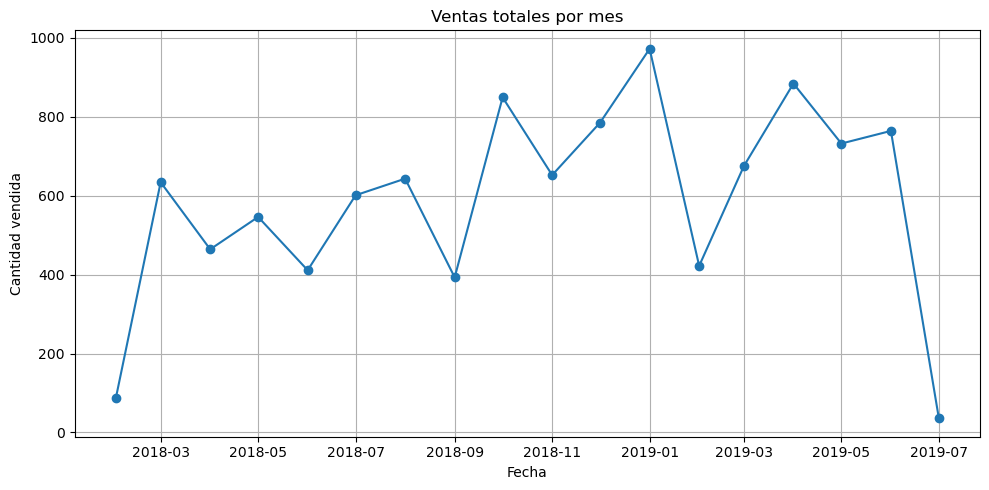

In [206]:
ventas_mensuales = fct_ventas.groupby(['ANIO', 'MES'])['QUANTITY'].sum().reset_index()

ventas_mensuales = ventas_mensuales.rename(columns={'ANIO': 'year', 'MES': 'month'})
ventas_mensuales['day'] = 1  # asignar día genérico para formar la fecha

ventas_mensuales['FECHA'] = pd.to_datetime(ventas_mensuales[['year', 'month', 'day']])

plt.figure(figsize=(10, 5))
plt.plot(ventas_mensuales['FECHA'], ventas_mensuales['QUANTITY'], marker='o')
plt.title('Ventas totales por mes')
plt.xlabel('Fecha')
plt.ylabel('Cantidad vendida')
plt.grid(True)
plt.tight_layout()
plt.show()


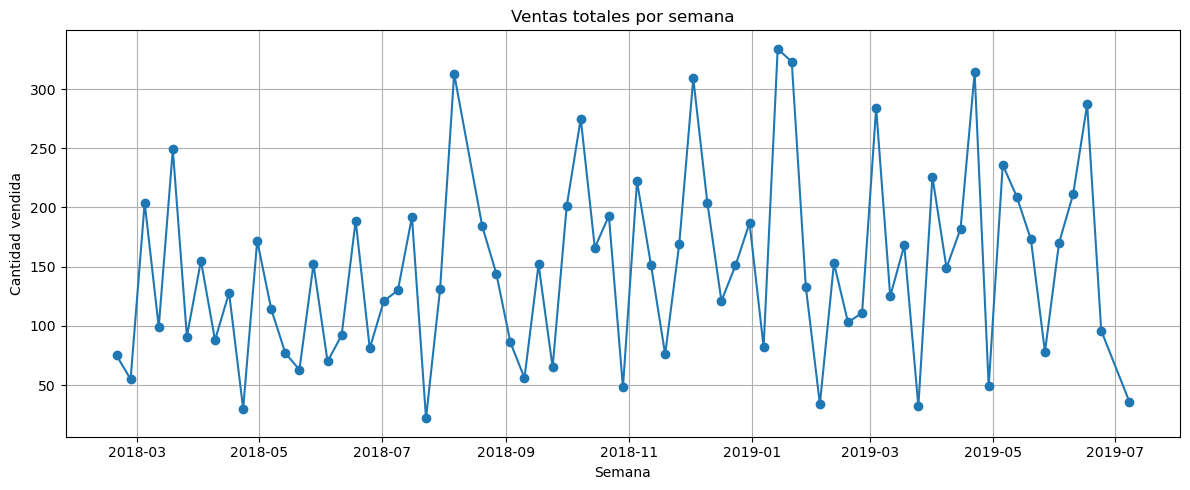

In [207]:
fct_ventas['DELIVERYDATE'] = pd.to_datetime(fct_ventas['DELIVERYDATE'])

ventas_semanales = fct_ventas.groupby(fct_ventas['DELIVERYDATE'].dt.to_period('W').apply(lambda r: r.start_time))['QUANTITY'].sum().reset_index()

plt.figure(figsize=(12, 5))
plt.plot(ventas_semanales['DELIVERYDATE'], ventas_semanales['QUANTITY'], marker='o')
plt.title('Ventas totales por semana')
plt.xlabel('Semana')
plt.ylabel('Cantidad vendida')
plt.grid(True)
plt.tight_layout()
plt.show()

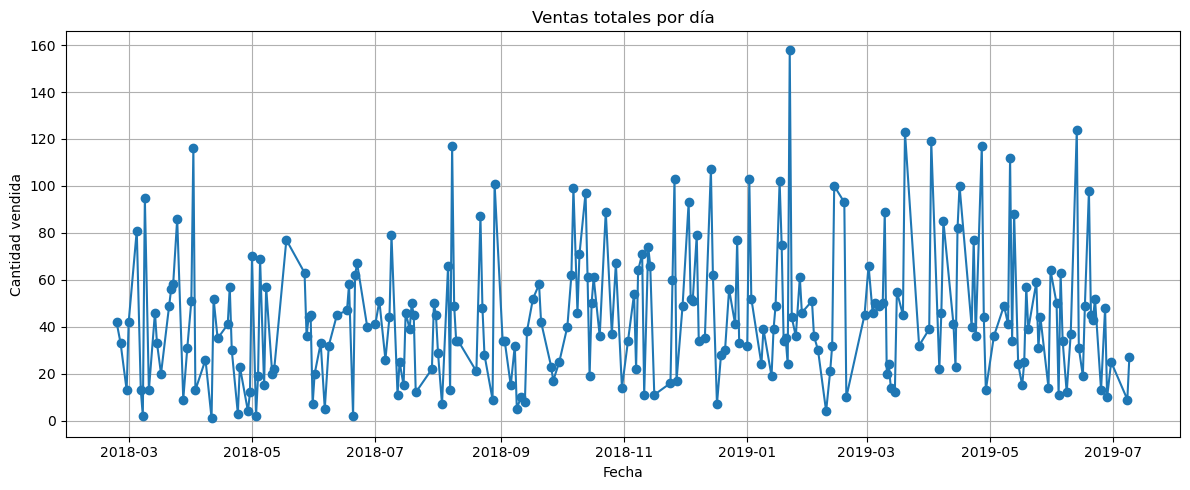

In [208]:
ventas_diarias = fct_ventas.groupby('DELIVERYDATE')['QUANTITY'].sum().reset_index()

plt.figure(figsize=(12, 5))
plt.plot(ventas_diarias['DELIVERYDATE'], ventas_diarias['QUANTITY'], marker='o')
plt.title('Ventas totales por día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad vendida')
plt.grid(True)
plt.tight_layout()
plt.show()

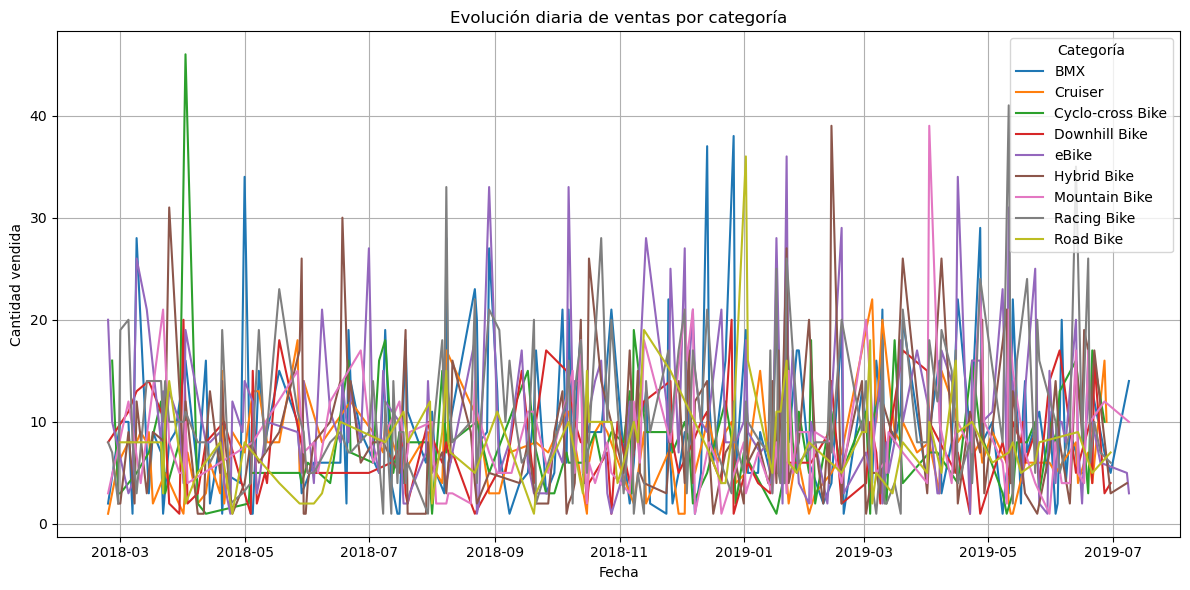

In [209]:
plt.figure(figsize=(12, 6))

for categoria in ventas_categoria_dia['SHORT_DESCR_CAT'].unique():
    df_cat = ventas_categoria_dia[ventas_categoria_dia['SHORT_DESCR_CAT'] == categoria]
    plt.plot(df_cat['DELIVERYDATE'], df_cat['QUANTITY'], label=categoria)

plt.title('Evolución diaria de ventas por categoría')
plt.xlabel('Fecha')
plt.ylabel('Cantidad vendida')
plt.legend(title='Categoría')
plt.grid(True)
plt.tight_layout()
plt.show()

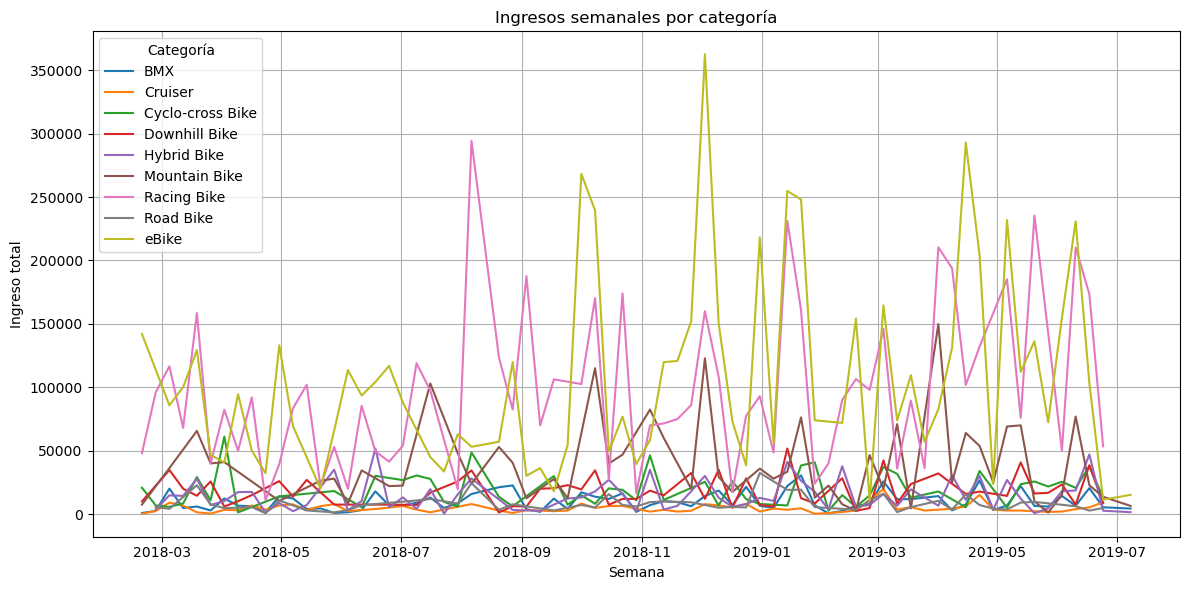

In [210]:
fct_ventas_cat['DELIVERYDATE'] = pd.to_datetime(fct_ventas_cat['DELIVERYDATE'])

fct_ventas_cat['SEMANA'] = fct_ventas_cat['DELIVERYDATE'].dt.to_period('W').apply(lambda r: r.start_time)

ingresos_semana_cat = fct_ventas_cat.groupby(['SHORT_DESCR_CAT', 'SEMANA'])['INGRESO_TOTAL'].sum().reset_index()

plt.figure(figsize=(12, 6))
for cat in ingresos_semana_cat['SHORT_DESCR_CAT'].unique():
    datos = ingresos_semana_cat[ingresos_semana_cat['SHORT_DESCR_CAT'] == cat]
    plt.plot(datos['SEMANA'], datos['INGRESO_TOTAL'], label=cat)

plt.title('Ingresos semanales por categoría')
plt.xlabel('Semana')
plt.ylabel('Ingreso total')
plt.legend(title='Categoría')
plt.grid(True)
plt.tight_layout()
plt.show()

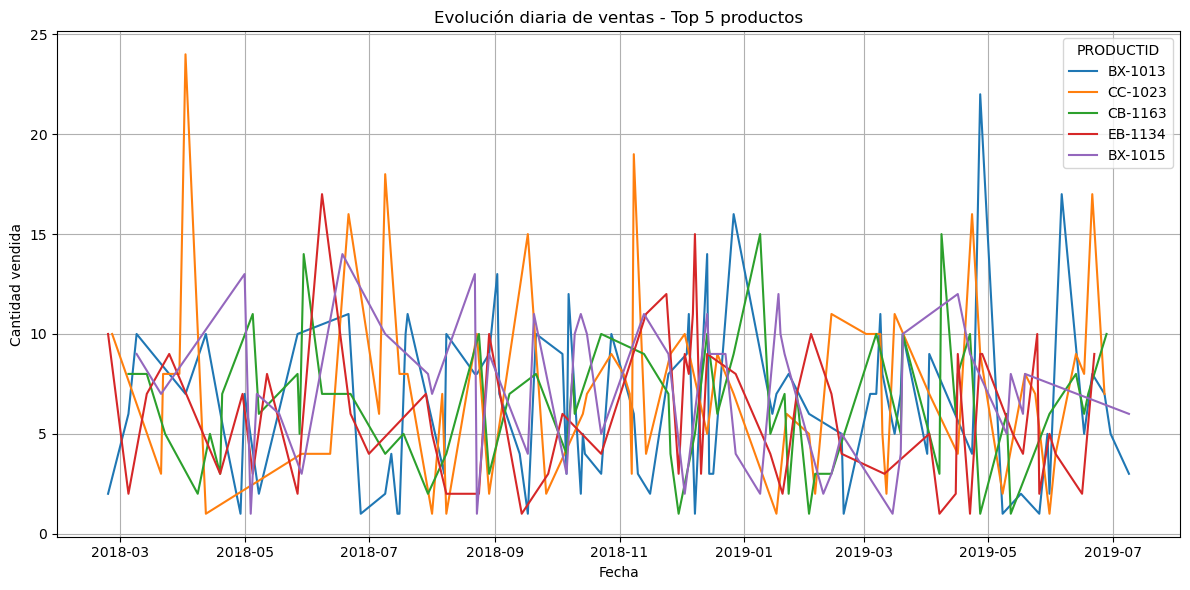

In [211]:
import matplotlib.pyplot as plt

top_productos = ventas_producto_dia.groupby('PRODUCTID')['QUANTITY'].sum().nlargest(5).index

plt.figure(figsize=(12, 6))

for producto in top_productos:
    datos = ventas_producto_dia[ventas_producto_dia['PRODUCTID'] == producto]
    plt.plot(datos['DELIVERYDATE'], datos['QUANTITY'], label=producto)

plt.title('Evolución diaria de ventas - Top 5 productos')
plt.xlabel('Fecha')
plt.ylabel('Cantidad vendida')
plt.legend(title='PRODUCTID')
plt.grid(True)
plt.tight_layout()
plt.show()

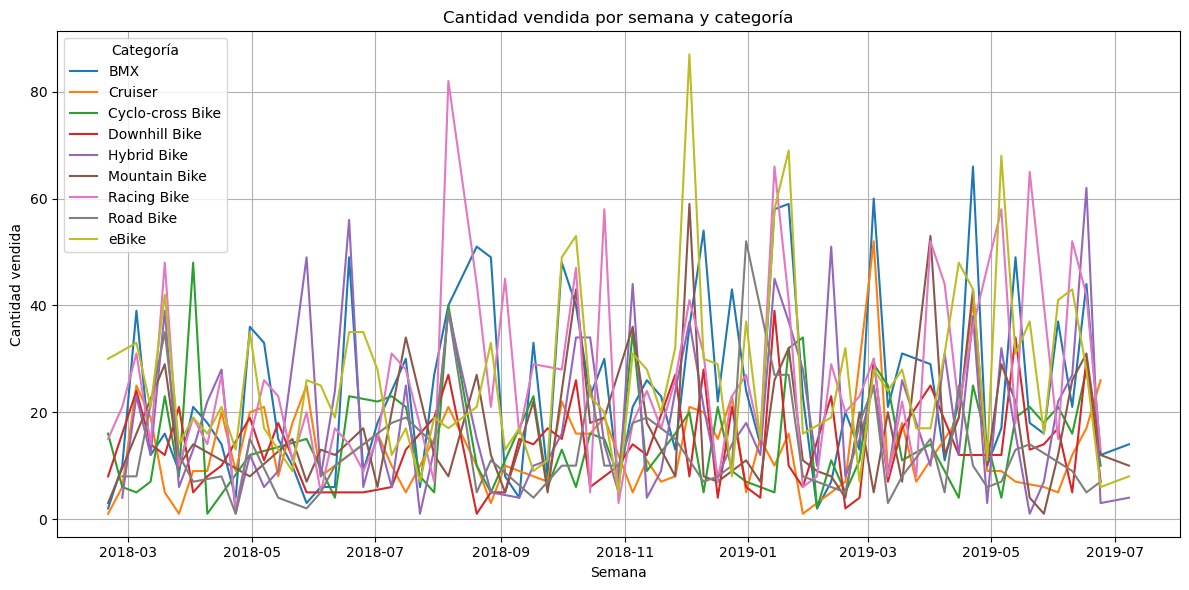

In [212]:
if 'SEMANA' not in fct_ventas_cat.columns:
    fct_ventas_cat['SEMANA'] = fct_ventas_cat['DELIVERYDATE'].dt.to_period('W').apply(lambda r: r.start_time)

cantidad_semana_cat = fct_ventas_cat.groupby(['SHORT_DESCR_CAT', 'SEMANA'])['QUANTITY'].sum().reset_index()

plt.figure(figsize=(12, 6))
for cat in cantidad_semana_cat['SHORT_DESCR_CAT'].unique():
    datos = cantidad_semana_cat[cantidad_semana_cat['SHORT_DESCR_CAT'] == cat]
    plt.plot(datos['SEMANA'], datos['QUANTITY'], label=cat)

plt.title('Cantidad vendida por semana y categoría')
plt.xlabel('Semana')
plt.ylabel('Cantidad vendida')
plt.legend(title='Categoría')
plt.grid(True)
plt.tight_layout()
plt.show()

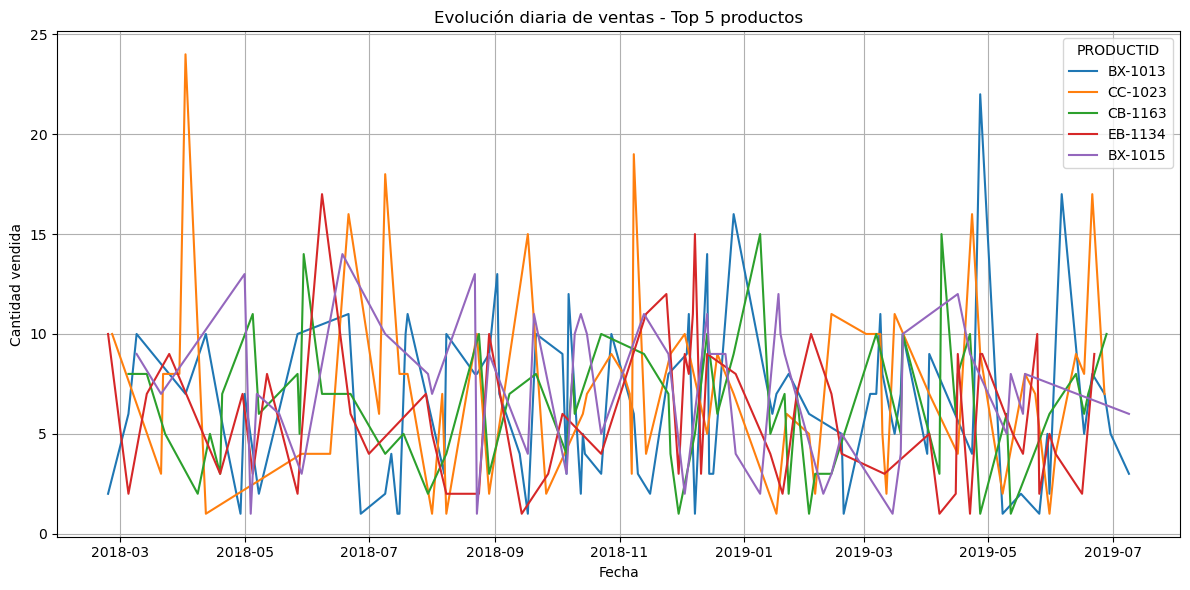

In [213]:
top_productos = fct_ventas.groupby('PRODUCTID')['QUANTITY'].sum().nlargest(5).index

plt.figure(figsize=(12, 6))

for producto in top_productos:
    df_prod = ventas_producto_dia[ventas_producto_dia['PRODUCTID'] == producto]
    plt.plot(df_prod['DELIVERYDATE'], df_prod['QUANTITY'], label=producto)

plt.title('Evolución diaria de ventas - Top 5 productos')
plt.xlabel('Fecha')
plt.ylabel('Cantidad vendida')
plt.legend(title='PRODUCTID')
plt.grid(True)
plt.tight_layout()
plt.show()

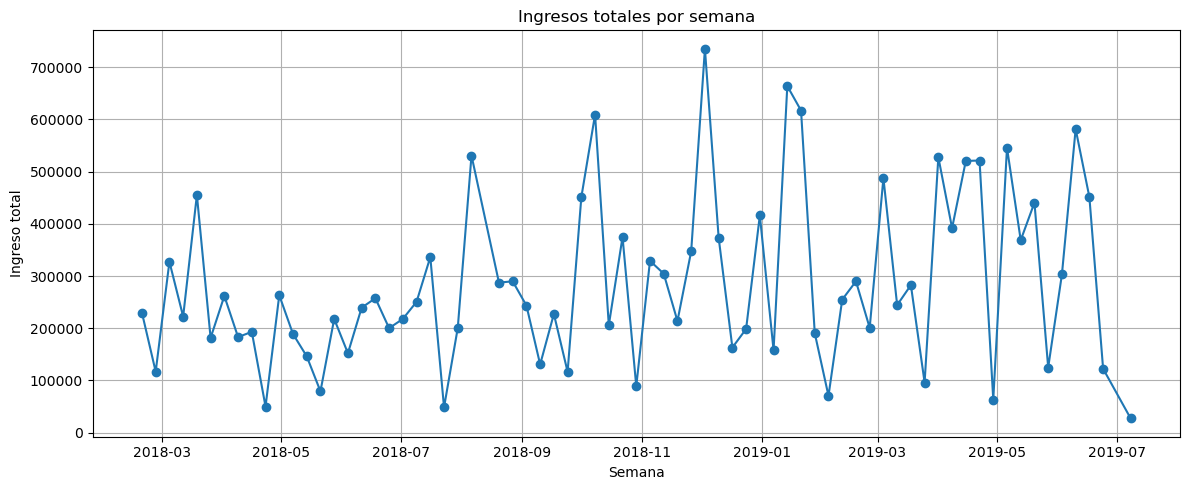

In [215]:
ingresos_semanales = fct_ventas.groupby(fct_ventas['DELIVERYDATE'].dt.to_period('W').apply(lambda r: r.start_time))['INGRESO_TOTAL'].sum().reset_index()

plt.figure(figsize=(12, 5))
plt.plot(ingresos_semanales['DELIVERYDATE'], ingresos_semanales['INGRESO_TOTAL'], marker='o')
plt.title('Ingresos totales por semana')
plt.xlabel('Semana')
plt.ylabel('Ingreso total')
plt.grid(True)
plt.tight_layout()
plt.show()

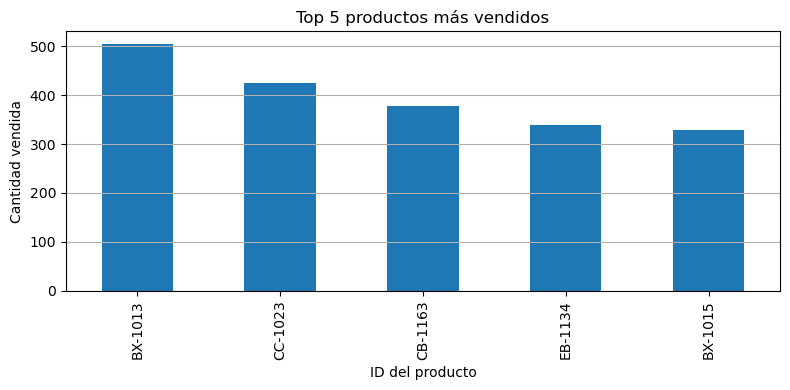

In [216]:
top5 = fct_ventas.groupby('PRODUCTID')['QUANTITY'].sum().sort_values(ascending=False).head(5)

plt.figure(figsize=(8, 4))
top5.plot(kind='bar')
plt.title('Top 5 productos más vendidos')
plt.ylabel('Cantidad vendida')
plt.xlabel('ID del producto')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

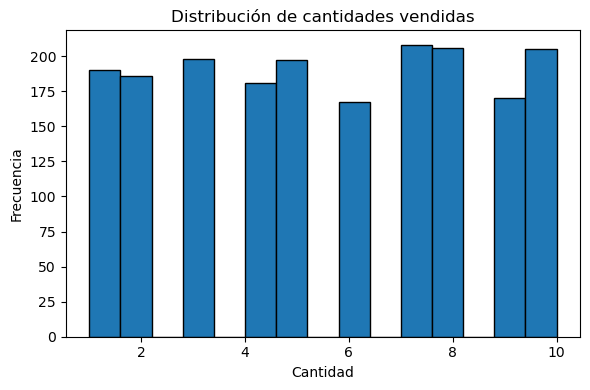

In [218]:
plt.figure(figsize=(6, 4))
plt.hist(fct_ventas['QUANTITY'], bins=15, edgecolor='black')
plt.title('Distribución de cantidades vendidas')
plt.xlabel('Cantidad')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

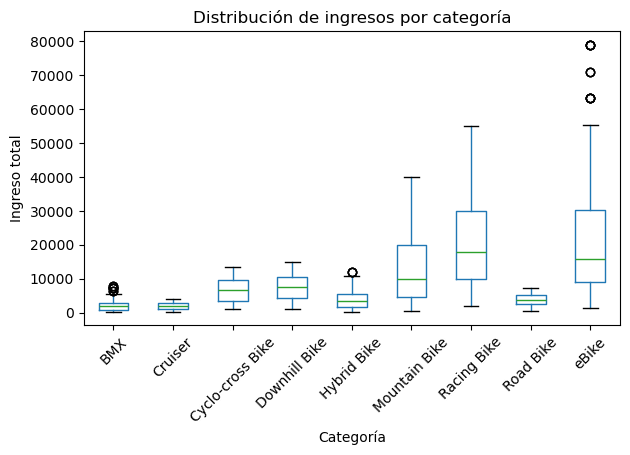

In [219]:
plt.figure(figsize=(10, 5))
fct_ventas_cat.boxplot(column='INGRESO_TOTAL', by='SHORT_DESCR_CAT', grid=False)
plt.title('Distribución de ingresos por categoría')
plt.suptitle('')
plt.xlabel('Categoría')
plt.ylabel('Ingreso total')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5. One-Hot Encoding


Codifición variables categóricas (al menos MES, DIA_SEMANA, CATEGORÍA)

In [220]:
fct_ventas_cat['DELIVERYDATE'] = pd.to_datetime(fct_ventas_cat['DELIVERYDATE'])
fct_ventas_cat['ANIO'] = fct_ventas_cat['DELIVERYDATE'].dt.year
fct_ventas_cat['MES'] = fct_ventas_cat['DELIVERYDATE'].dt.month
fct_ventas_cat['DIA'] = fct_ventas_cat['DELIVERYDATE'].dt.day
fct_ventas_cat['DIA_SEMANA'] = fct_ventas_cat['DELIVERYDATE'].dt.day_name()

In [221]:
fct_ventas_cat['DIA_SEMANA'] = fct_ventas_cat['DIA_SEMANA'].astype(str)
fct_ventas_cat['MES'] = fct_ventas_cat['MES'].astype(str)
fct_ventas_cat['SHORT_DESCR_CAT'] = fct_ventas_cat['SHORT_DESCR_CAT'].astype(str)

fct_encoded = pd.get_dummies(fct_ventas_cat, columns=['DIA_SEMANA', 'MES', 'SHORT_DESCR_CAT'], drop_first=True)

In [222]:
def preparar_para_modelo(df, columnas_a_codificar=['DIA_SEMANA', 'MES', 'SHORT_DESCR_CAT']):
    import pandas as pd
    
    df = df.copy()

    df['DELIVERYDATE'] = pd.to_datetime(df['DELIVERYDATE'])

    if 'ANIO' not in df.columns:
        df['ANIO'] = df['DELIVERYDATE'].dt.year
    if 'MES' not in df.columns:
        df['MES'] = df['DELIVERYDATE'].dt.month
    if 'DIA' not in df.columns:
        df['DIA'] = df['DELIVERYDATE'].dt.day
    if 'DIA_SEMANA' not in df.columns:
        df['DIA_SEMANA'] = df['DELIVERYDATE'].dt.day_name()

    for col in columnas_a_codificar:
        if col in df.columns:
            df[col] = df[col].astype(str)

    df_encoded = pd.get_dummies(df, columns=columnas_a_codificar, drop_first=True)

    return df_encoded

In [223]:
fct_encoded = preparar_para_modelo(fct_ventas_cat)

Versión general: sin codificar PRODUCTID

In [224]:
fct_encoded_general = preparar_para_modelo(fct_ventas_cat)

Versión específica: con PRODUCTID codificado (One-Hot)

In [225]:
fct_ventas_cat_prod = fct_ventas_cat.copy()

fct_ventas_cat_prod['PRODUCTID'] = fct_ventas_cat_prod['PRODUCTID'].astype(str)

fct_encoded_producto = preparar_para_modelo(
    fct_ventas_cat_prod,
    columnas_a_codificar=['DIA_SEMANA', 'MES', 'SHORT_DESCR_CAT', 'PRODUCTID']
)

Escalado de columnas numéricas

In [226]:
from sklearn.preprocessing import StandardScaler

columnas_a_escalar = ['QUANTITY', 'PRICE_UNITARIO', 'INGRESO_TOTAL']

scaler = StandardScaler()

fct_encoded_general[columnas_a_escalar] = scaler.fit_transform(fct_encoded_general[columnas_a_escalar])

fct_encoded_producto[columnas_a_escalar] = scaler.fit_transform(fct_encoded_producto[columnas_a_escalar])

## 6. Selección de variables relevantes

In [227]:
corr = fct_encoded_general.corr(numeric_only=True)

correlacion_quantity = corr['QUANTITY'].sort_values(ascending=False)
print(correlacion_quantity)

QUANTITY                            1.000000
INGRESO_TOTAL                       0.432370
SHORT_DESCR_CAT_Road Bike           0.041718
MES_3                               0.030173
SHORT_DESCR_CAT_Downhill Bike       0.022827
DIA_SEMANA_Tuesday                  0.020975
DIA_SEMANA_Saturday                 0.018200
MES_6                               0.017726
DIA_SEMANA_Thursday                 0.017324
ANIO                                0.016395
SHORT_DESCR_CAT_Racing Bike         0.015149
MES_8                               0.013963
MES_10                              0.013188
DIA_SEMANA_Wednesday                0.008797
PRICE_UNITARIO                      0.007191
PRICE                               0.007191
SHORT_DESCR_CAT_Cyclo-cross Bike    0.006648
MES_12                              0.003676
DIA_SEMANA_Sunday                   0.000790
SHORT_DESCR_CAT_Mountain Bike       0.000289
SHORT_DESCR_CAT_Cruiser            -0.000325
MES_11                             -0.000396
DIA       

In [228]:
from sklearn.feature_selection import VarianceThreshold

X = fct_encoded_general.drop(columns=['QUANTITY'])

X_num = X.select_dtypes(include=['number'])

selector = VarianceThreshold(threshold=0.01)
X_reducido = selector.fit_transform(X_num)

columnas_seleccionadas = X_num.columns[selector.get_support()]
print("Columnas con varianza suficiente:")
print(columnas_seleccionadas)

Columnas con varianza suficiente:
Index(['PRICE_UNITARIO', 'PRICE', 'ANIO', 'DIA', 'INGRESO_TOTAL'], dtype='object')


In [229]:
fct_encoded_general.drop(columns=['PRICE'], inplace=True)
fct_encoded_producto.drop(columns=['PRICE'], inplace=True)

In [230]:
from sklearn.feature_selection import SelectKBest, f_regression

X = fct_encoded_general.drop(columns=['QUANTITY'])
X_num = X.select_dtypes(include=['number'])  # Solo columnas numéricas

y = fct_encoded_general['QUANTITY']

selector = SelectKBest(score_func=f_regression, k=10)
X_kbest = selector.fit_transform(X_num, y)

columnas_kbest = X_num.columns[selector.get_support()]
print("Mejores columnas según SelectKBest:", columnas_kbest)

Mejores columnas según SelectKBest: Index(['PRICE_UNITARIO', 'ANIO', 'DIA', 'INGRESO_TOTAL'], dtype='object')


c:\Users\jpare\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=4. All the features will be returned.
  warnings.warn(


## 7. Lag Features (Ventanas anteriores de temporalidad)

In [231]:
fct_lags = fct_ventas_cat.sort_values(['PRODUCTID', 'DELIVERYDATE']).copy()

fct_lags['QUANTITY_LAG_1'] = fct_lags.groupby('PRODUCTID')['QUANTITY'].shift(1)
fct_lags['QUANTITY_LAG_7'] = fct_lags.groupby('PRODUCTID')['QUANTITY'].shift(7)

fct_lags['QUANTITY_ROLLING_3'] = fct_lags.groupby('PRODUCTID')['QUANTITY'].rolling(window=3).mean().reset_index(0, drop=True)
fct_lags['QUANTITY_ROLLING_7'] = fct_lags.groupby('PRODUCTID')['QUANTITY'].rolling(window=7).mean().reset_index(0, drop=True)

Imputación de valores NAN en el LAG features

In [232]:
fct_lags['QUANTITY_LAG_1'] = fct_lags['QUANTITY_LAG_1'].fillna(0)
fct_lags['QUANTITY_LAG_7'] = fct_lags['QUANTITY_LAG_7'].fillna(0)
fct_lags['QUANTITY_ROLLING_3'] = fct_lags['QUANTITY_ROLLING_3'].fillna(0)
fct_lags['QUANTITY_ROLLING_7'] = fct_lags['QUANTITY_ROLLING_7'].fillna(0)

## Exportar nuevas tablas procesadas

In [234]:
fct_lags.to_csv("../datasets/processed/fct_lags.csv", index=False)
fct_encoded_general.to_csv("../datasets/processed/fct_encoded_general.csv", index=False)
fct_encoded_producto.to_csv("../datasets/processed/fct_encoded_producto.csv", index=False)